<a href="https://colab.research.google.com/github/yassine-cherni/NLP/blob/main/Resnet50_Lstm-Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, models
from IPython import display
from tensorflow.keras.applications import ResNet50

In [12]:
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Define dataset path
DATASET_PATH = '/content/drive/MyDrive/DATA/AUDIO/'
data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['LIGHT_ON' 'DISABLE_LANE_ASSIST' 'TURN_Off_VENTILATION'
 'TURN_ON_VENTILATION' 'POWER_ON_FOCUS' 'POWER_OFF_FOCUS'
 'ACTIVATE_LANE_ASSIST' 'LIGHT_OFF' '.ipynb_checkpoints']


In [13]:
# Load dataset
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both'
)

label_names = np.array(train_ds.class_names)
print("Label names:", label_names)

def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

def make_spec_ds(ds):
    return ds.map(map_func=lambda audio, label: (get_spectrogram(audio), label), num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

input_shape = (124, 129, 1)  # Spectrogram shape
num_labels = len(label_names)

Found 8014 files belonging to 8 classes.
Using 6412 files for training.
Using 1602 files for validation.
Label names: ['ACTIVATE_LANE_ASSIST' 'DISABLE_LANE_ASSIST' 'LIGHT_OFF' 'LIGHT_ON'
 'POWER_OFF_FOCUS' 'POWER_ON_FOCUS' 'TURN_ON_VENTILATION'
 'TURN_Off_VENTILATION']


In [14]:
# Create the model
inputs = tf.keras.Input(shape=input_shape)

# Resizing and normalization
x = layers.Resizing(224, 224)(inputs)
norm_layer = layers.Normalization()
norm_layer.adapt(train_spectrogram_ds.map(lambda spec, label: spec))
x = norm_layer(x)

# Convert to 3 channels for ResNet50
x = layers.Conv2D(3, (3, 3), padding='same')(x)

# Load pre-trained ResNet50 model
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add output layers
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Reshape((1, x.shape[-1]))(x)  # Reshape for LSTM
x = layers.LSTM(128)(x)  # LSTM layer

outputs = layers.Dense(num_labels)(x)  # Final output layer

# Build and compile the model
model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

# Train the model
EPOCHS = 100
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS
)



94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 124, 129, 1)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 1)       0         
                                                                 
 normalization (Normalizati  (None, 224, 224, 1)       3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0      

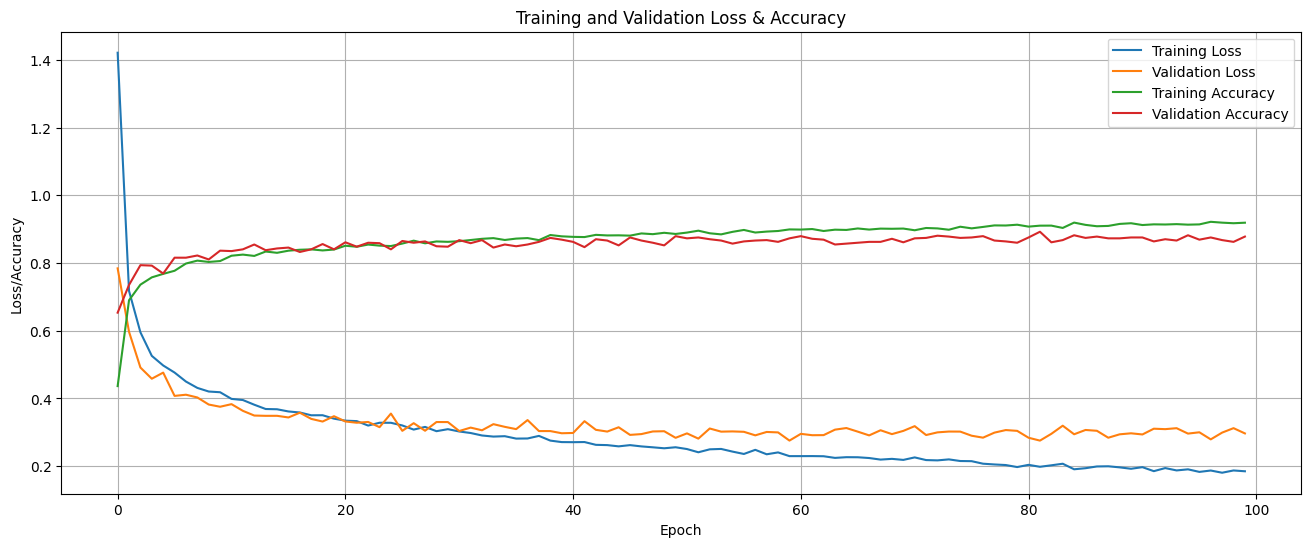

In [15]:
# Data Visualization
plt.figure(figsize=(16, 6))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.title('Training and Validation Loss & Accuracy')
plt.grid(True)
plt.show()

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
# Save the model
model.save("Resnet50-LSTM.h5")

# Load the saved model
loaded_model = keras.models.load_model("Resnet50-LSTM.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
test_loss, test_acc = loaded_model.evaluate(test_spectrogram_ds, verbose=2)
print("Test Accuracy:", test_acc)

# Make predictions
predictions = loaded_model.predict(test_spectrogram_ds)

13/13 - 7s - loss: 0.2847 - accuracy: 0.8786 - 7s/epoch - 550ms/step
Test Accuracy: 0.8786057829856873
13/13 [==============================] - 3s 151ms/step


THIS MODEL IS GREAT BUT I WILL CHOISE THE RNN6LSTM MODEL